# Computing array response functions

This notebook can be used to compute array response/transfer functions.

In [1]:
%matplotlib ipympl

import geometry
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import obspy
import obspy.clients.fdsn
import pathlib
import warnings

warnings.filterwarnings('ignore')

PHI = (1 + np.sqrt(5)) / 2

## 1. Introduction

Consider a plane wave propagating across an array of $N$ seismometers with slowness vector $\mathbf{s}_0$. Assuming a noise- and attentuation-free, homogeneous medium, the signal recorded by receiver $j$ is $u_j(t) = u_0(t - \mathbf{r}_j \cdot \mathbf{s}_0$) in which $u_0(t)$ represents the signal recorded by some reference receiver at time $t$ and $\mathbf{r}_j$ represents the position vector of receiver $j$ relative to the reference receiver.

The beam formed by stacking waveforms from all $N$ receivers after aligning them temporally with the reference signal (the signal recorded by the reference receiver),  assuming the wavefront propagates with (potentially incorrect) slowness $\mathbf{s}$ is

\begin{align}
    b(t, \mathbf{s}; \mathbf{s}_0) 
        &= \frac{1}{N} \sum_{j=0}^{N-1} u_j(t + \mathbf{r}_j \cdot \mathbf{s}) \\
        &= \frac{1}{N} \sum_{j=0}^{N-1} u_0(t - \mathbf{r}_j \cdot \mathbf{s}_0 + \mathbf{r}_j \cdot \mathbf{s}) \\
        &= \frac{1}{N} \sum_{j=0}^{N-1} u_0(t + \mathbf{r}_j \cdot \left( \mathbf{s} - \mathbf{s}_0 \right) )
\end{align}

and the power of this beam is

\begin{align}
    P(\mathbf{s}; \mathbf{s}_0)
        &= \int_{-\infty}^{\infty}b^2(t, \mathbf{s}; \mathbf{s}_0) dt \\
        &= \int_{-\infty}^{\infty} \left| \frac{1}{N} \sum_{j=0}^{N-1} u_0 \left( t + \mathbf{r}_j \cdot \left( \mathbf{s} - \mathbf{s}_0 \right) \right) \right|^2 dt \\
        &= \frac{1}{N^2} \int_{-\infty}^{\infty} \left| \mathcal{F} \left\{ \sum_{j=0}^{N-1} u_0 \left( t + \mathbf{r}_j \cdot \left( \mathbf{s} - \mathbf{s}_0 \right) \right) \right\} \right|^2 d\omega \\
        &= \frac{1}{N^2} \int_{-\infty}^{\infty} \left| \sum_{j=0}^{N-1} \mathcal{F} \left\{ u_0 \left( t + \mathbf{r}_j \cdot \left( \mathbf{s} - \mathbf{s}_0 \right) \right) \right\} \right|^2 d\omega \\
        &= \frac{1}{N^2} \int_{-\infty}^{\infty} \left| \sum_{j=0}^{N-1} e^{i \omega \mathbf{r}_j \cdot \left( \mathbf{s} - \mathbf{s}_0 \right)}\widehat{u_0} \left( \omega \right) \right|^2 d\omega
\end{align}

in  which $\mathcal{F}\left\{ \cdot \right\}$ represents the forward Fourier operator and $\widehat{u}_0(\omega) = \mathcal{F}\left\{u_0(t)\right\}$.

Thus, the array response in slowness space to an incoming plane wave characterized by actual slowness $\mathbf{s}_0$ and reference seismogram $u_0(t)$ is

\begin{equation}
    P\left( \mathbf{s}; \mathbf{s}_0 \right) = \frac{1}{N^2} \int_{-\infty}^{\infty} \left| \sum_{j=0}^{N-1} e^{i \omega \mathbf{r}_j \cdot \left( \mathbf{s} - \mathbf{s}_0 \right)}\widehat{u_0} \left( \omega \right) \right|^2 d\omega.
\end{equation}

This can also be written in terms of $\delta \mathbf{s} = \mathbf{s} - \mathbf{s}_0$:

\begin{equation}
    P\left( \delta \mathbf{s} \right) = \frac{1}{N^2} \int_{-\infty}^{\infty} \left| \sum_{j=0}^{N-1} e^{i \omega \mathbf{r}_j \cdot \delta \mathbf{s}}\widehat{u_0} \left( \omega \right) \right|^2 d\omega.
\end{equation}

The array response quantifies the power of the beam computed assuming a slowness value that differs from the actual slowness of the incoming wave by amount $\delta \mathbf{s}$.

Note: **Azimuth in this notebook is measured assuming the geographic convention (i.e., in degrees from north (positive clockwise)).**

## 2. Implementation

In [2]:
def compute_response(
    geom, 
    trace,
    slo_grid,
    coord_sys='cartesian',
):
    '''
    Compute the response of an array with arbitrary geometry to an
    arbitrary reference seismogram.
    
    Arguments
    =========
    geom :: pandas.DataFrame :: The geometry of the array to compute
        response for. Must have fields ['x', 'y'] which are receiver
        relative coordinates measured in kilometers.
    trace :: obspy.Trace :: The reference seismogram with respect to
        which to compute the array response.
    slo_grid :: np.array[2, m, n] :: Grid of slowness values for which
        to compute response amplitude. This grid can specify the vector
        slowness in either (1) Cartesian components u_x and u_y or (2)
        in polar coordinates A*exp(-i*azim).
    coord_sys :: str :: Specifies whether `slo_grid` specifies slowness
        values in cartesian or polar form. Acceptable values are 'POLAR'
        and 'CARTESIAN'.
        
    Returns
    =======
    power :: np.array[m, n] :: Returns the response amplitude for each
        slowness specified by `slo_grid`.
    '''
    if coord_sys.upper() == 'POLAR':
        slo_grid = np.stack(polar2xy(*slo_grid))
    elif coord_sys.upper() != 'CARTESIAN':
        raise ValueError(f'Unrecognized coordinate system: {coord_sys}.')

    # Compute FFT of reference seismogram.
    u_hat = np.fft.fft(trace.data)
    # Compute frequencies of FFT samples.
    omega = np.fft.fftfreq(trace.stats.npts, d=trace.stats.delta)
    # Compute the sample interval in frequency domain.
    d_omega = trace.stats.sampling_rate / trace.stats.npts
    
    xy = geom[['x', 'y']].values.T
    # Compute time delay (dot product of the position and relative
    # slowness vector) for each receiver-slowness pair.
    # `tau` has shape (n_rx, n_slo_1, n_slo_2)
    tau = np.sum(xy[:, :, np.newaxis, np.newaxis] * slo_grid[:, np.newaxis], axis=0)
    # Compute the exponential term
    # `exp` has shape (n_omega, n_rx, n_slo_1, n_slo_2)
    exp = np.exp(1j * omega[:, np.newaxis, np.newaxis, np.newaxis] * tau[np.newaxis])
    # Sum over receivers.
    # `power` has shape (n_omega, n_slo_1, n_slo_2)
    power = np.sum(exp, axis=1) * u_hat[:, np.newaxis, np.newaxis]
    # Integrate square of absolute value of omega.
    power = np.sum(np.square(np.abs(power)) * d_omega, axis=0) / len(xy)**2
    # Convert power to dB down from max value.
    power = 10 * np.log10(power / np.max(power))

    return power


def plot_response(geom, trace, power, slo_grid, coord_sys):
    gs = mpl.gridspec.GridSpec(
        nrows=2, 
        ncols=3, 
        height_ratios=[1, 2],
        width_ratios=[1, 1, 0.08]
    )

    fig = plt.figure(figsize=(8.5, 6))

    # Plot the seismogram
    ax0 = fig.add_subplot(gs[0, :])
    ax0.plot(trace.times(), trace.data, color='k', linewidth=1)
    ax0.set_xlim(0, np.max(trace.times()))
    ax0.set_xlabel('Elapsed time (s)')
    ax0.xaxis.set_label_position('top')
    ax0.xaxis.tick_top()

    # Plot the array geometry
    ax1 = fig.add_subplot(gs[1, 0], aspect=1)
    ax1.scatter(
        geom['x'],
        geom['y'],
        s=64,
        marker='v',
        facecolor='tab:blue',
        edgecolor='k',
        linewidth=1,
        alpha=0.75
    )
    vmin = np.min(geom[['x', 'y']].values)
    vmax = np.max(geom[['x', 'y']].values)
    dv = vmax - vmin
    ax1.set_xlim(vmin-0.1*dv, vmax+0.1*dv)
    ax1.set_xlabel('E-W (km)')
    ax1.set_ylabel('N-S (km)')
    ax1.grid(ls=(10, (8, 5)))

    if coord_sys.upper() == 'CARTESIAN':
        ax2 = fig.add_subplot(gs[1, 1], aspect=1)
        qmesh = ax2.pcolormesh(
            slo_grid[0], 
            slo_grid[1], 
            power,
            cmap=plt.get_cmap('magma')
        )
        ax2.grid(color='gray', ls=(2, (10, 5)), lw=1)
        ax2.set_xlabel('$\delta u_x$ (s/km)')
        ax2.set_ylabel('$\delta u_y$ (s/km)')

    elif coord_sys.upper() == 'POLAR':
        ax2 = fig.add_subplot(gs[1, 1], projection='polar')
        ax2.grid(True)
        qmesh = ax2.pcolormesh(
            np.radians(slo_grid[1]), 
            slo_grid[0], 
            power,
            cmap=plt.get_cmap('magma')
        )
        ax2.grid(color='gray', ls=(2, (10, 5)), lw=1)
        ax2.tick_params(axis='y', colors='c', pad=15)
        ax2.set_theta_zero_location('N')
        ax2.set_theta_direction(-1)
    else:
        raise ValueError(f'Unrecognized coordinate system: {coord_sys}.')

    cax = fig.add_subplot(gs[1, 2])
    cbar = fig.colorbar(qmesh, cax=cax)
    cbar.set_label('Beam power (dB)')


def polar2xy(mag, az):
    '''
    Convert vector in polar coordinates to Cartesian.
    
    Arguments
    =========
    mag :: float :: (arbitrary units) The vector magnitude.
    az :: float :: (degrees) The vector azimuth measured in degrees from north (positive clockwise).
    
    Returns
    =======
    np.array([x, y]) :: float :: (same units as `mag`) The Cartesian vector components.
    '''
    theta = np.pi/2 - np.radians(az)
    return mag * np.array([np.cos(theta), np.sin(theta)])


def xy2polar(x, y):
    mag = np.sqrt(np.square(x) + np.square(y))
    az = np.degrees(np.pi/2 - np.arctan2(y, x))
    return mag, az

## 3. Example: Computing the response of an array

First, create an array geometry. See the `geometry` module and the `build_array_geometry.ipynb` notebook for documentation on building array geometries.

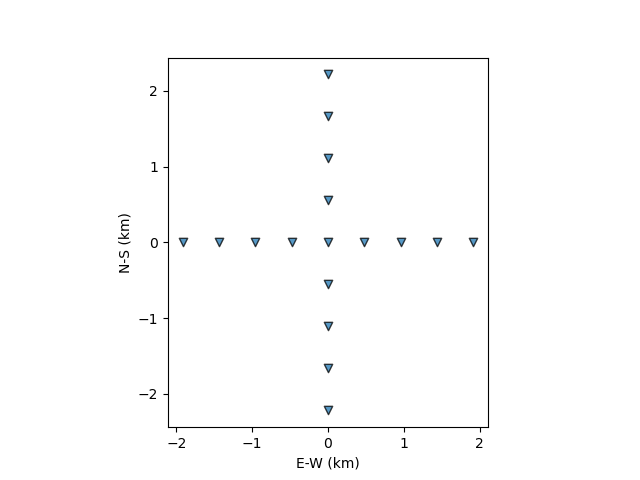

In [3]:
lon_0, lat_0 =-71.4, 30.5
geom = geometry.build_cross_antenna_geometry(
    lon_0, lat_0, 8, 8, 0.005, 0.005
)

plt.close('all')
fig, ax = plt.subplots()
ax.scatter(geom['x'], geom['y'], marker='v', facecolor='tab:blue', edgecolor='k', alpha=0.75)
ax.set_xlabel('E-W (km)')
ax.set_ylabel('N-S (km)')
ax.set_aspect(1)

Next, create a reference seismogram. In this case, the seismogram will be a unit impulse.

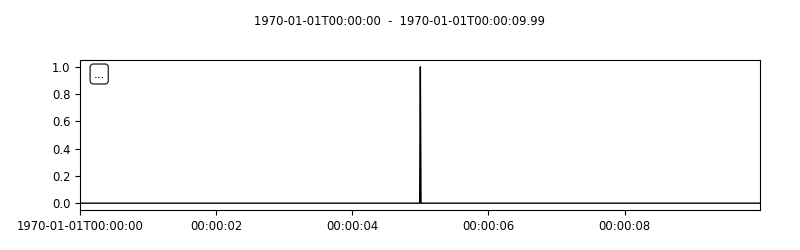

In [4]:
trace = obspy.Trace(
    np.zeros(1000),
    header=dict(
        sampling_rate=100
    )
)
trace.data[trace.stats.npts//2] = 1
trace.plot(handle=True);

Finally, create a slowness grid then compute and plot the response. In this case, the slowness grid is specified in polar coordinates.

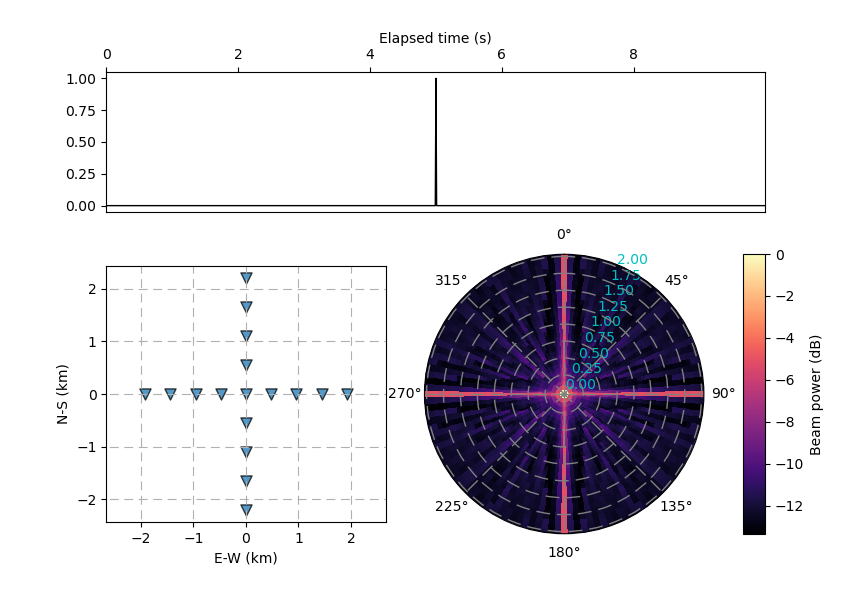

In [5]:
coord_sys = 'polar'
slo_grid = np.mgrid[
    0: 2: 32j,   # The slowness magnitude range.
    0: 360: 129j # The slowness azimuth range.
]
power = compute_response(
    geom, 
    trace,
    slo_grid,
    coord_sys=coord_sys
)
plot_response(geom, trace, power, slo_grid, coord_sys)

The slowness grid can also be specified in Cartesian coordinates.

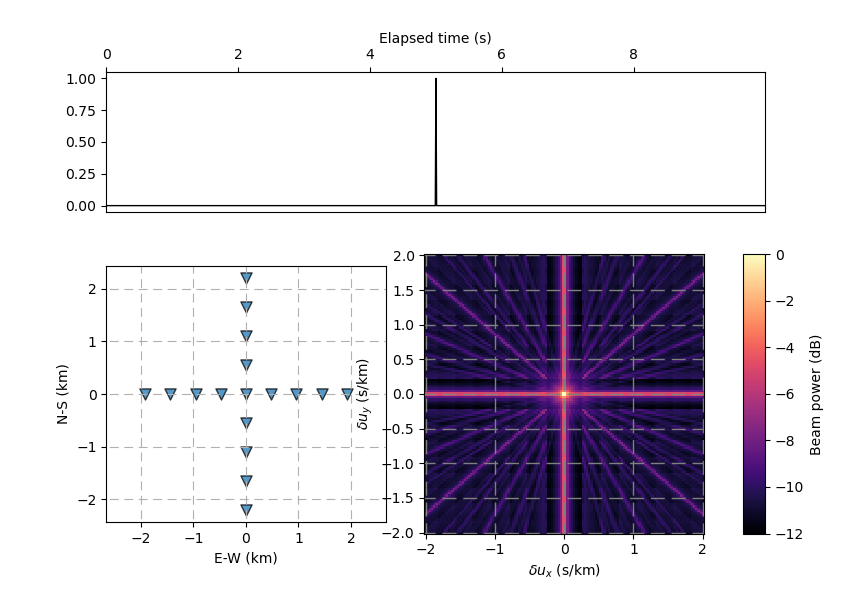

In [6]:
coord_sys = 'cartesian'
slo_grid = np.mgrid[
    -2: 2: 128j, # The x-component of the slowness vector.
    -2: 2: 128j  # The y-component of the slowness vector.
]
power = compute_response(
    geom, 
    trace,
    slo_grid,
    coord_sys=coord_sys
)
plot_response(geom, trace, power, slo_grid, coord_sys)

The array response can also be computed for an arbitrary reference seismogram

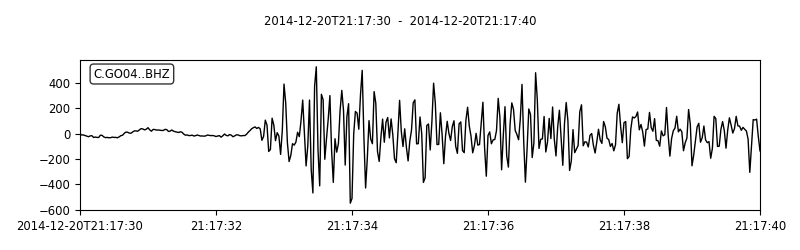

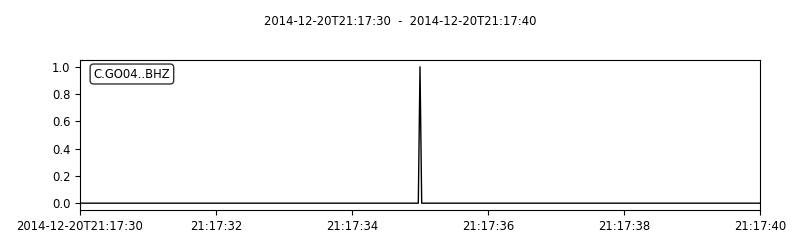

In [7]:
network    = 'C'
station    = 'GO04'
location   = '*'
channel    = 'BHZ'
start_time = obspy.UTCDateTime('2014-12-20T21:17:30Z')
end_time   = start_time + 10
freq       = 1/2 # Corner frequency for high-pass filter.

client = obspy.clients.fdsn.Client()
stream = client.get_waveforms(
    network,
    station,
    location,
    channel,
    start_time-5,
    end_time
)
trace = stream[0]
if freq > 0:
    trace.filter('highpass', freq=freq, zerophase=True)
trace.trim(starttime=start_time)

event_trace = trace.copy()
impulse_trace = trace.copy()
impulse_trace.data = np.zeros_like(impulse_trace.data)
impulse_trace.data[impulse_trace.stats.npts//2] = 1
impulse_trace.plot(handle=True);

plt.close('all')
event_trace.plot(handle=True);
impulse_trace.plot(handle=True);

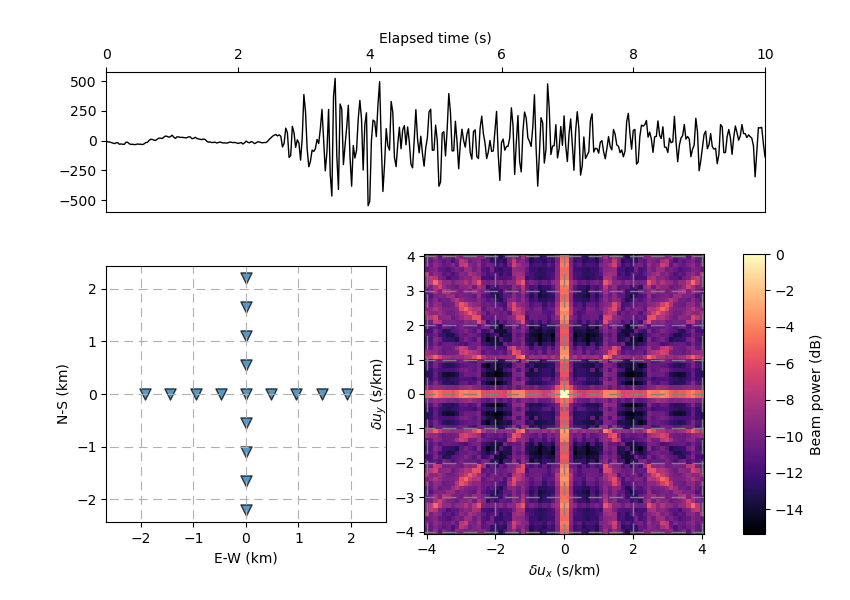

In [8]:
trace = event_trace.copy()

coord_sys = 'cartesian'
slo_grid = np.mgrid[
    -4: 4: 64j,   # The slowness magnitude range.
    -4: 4: 64j # The slowness azimuth range.
]
power = compute_response(
    geom, 
    trace,
    slo_grid,
    coord_sys=coord_sys
)
plot_response(geom, trace, power, slo_grid, coord_sys)

## 4. Comparative analysis

This section implements a comparative analysis for investigating various array design choices. The primary parameters investigated here are: (1) the array type; (2) the array aperture; (3) the number of receivers; and (4) low corner frequency.

In [9]:
import geometry
import matplotlib as mpl

class NameSpace:
    pass

def build_array_geometries(x_var, y_var, fixed_vars, constants):
    ns = NameSpace()
    geoms = dict()

    for key in fixed_vars:
        setattr(ns, key, fixed_vars[key])
    for key in constants:
        setattr(ns, key, constants[key])
    
    for x in x_var[1]:
        setattr(ns, x_var[0], x)
        geoms[x] = dict()
        for y in y_var[1]:
            setattr(ns, y_var[0], y)
            if ns.array_type == 'Regular':
                n_x = n_y = ns.n_rx // 2
                d_x = d_y = ns.aperture / n_x
                geom = geometry.build_cross_antenna_geometry(
                    ns.lon_0, 
                    ns.lat_0, 
                    n_x, 
                    n_y, 
                    d_x, 
                    d_y
                )
            elif ns.array_type == 'Log-periodic':
                n_x = n_y = ns.n_rx // 2
                d_lon = d_lat = ns.aperture / np.sum([ns.sigma**j for j in range(n_x)])
                geom = geometry.build_lp_ortho_antenna_geometry(
                    ns.lon_0, 
                    ns.lat_0, 
                    n_x, 
                    n_y, 
                    d_lon, 
                    d_lat, 
                    ns.sigma, 
                    ns.sigma, 
                    recenter=True
                )
            elif ns.array_type == 'Ring':
                geom = geometry.build_ring_antenna_geometry(
                    ns.lon_0, 
                    ns.lat_0, 
                    ns.n_rx//2, 
                    [ns.aperture/5, ns.aperture/2]
                )
            elif ns.array_type == 'Spiral':
                r0 = (ns.aperture/2)*geometry.phi**-4
                n_arms = 4
                n_rx_per_arm = ns.n_rx // 4
                geom = geometry.build_spiral_antenna_geometry(
                    ns.lon_0, 
                    ns.lat_0, 
                    n_arms, 
                    n_rx_per_arm, 
                    r0
                )
            else:
                raise ValueError(f'Unrecognized array type: {ns.array_type}.')
            geoms[x][y] = geom
            
    return geoms


def plot_arrays(geoms, x_var, y_var, fixed_vars, x_prefix=None, x_suffix=None, y_prefix=None, y_suffix=None):
    '''
    A utility function to plot array geometries for cross-reference
    against response suites.
    '''

    # ns = NameSpace()
    # for key in fixed:
    #     setattr(ns, key, fixed[key])
    
    fig_size = 2*len(x_var[1]), 2*len(y_var[1])
    fig, axes = plt.subplots(
        figsize=fig_size,
        nrows=len(y_var[1]), 
        ncols=len(x_var[1]), 
        sharex=True, 
        sharey=True, 
        subplot_kw=dict(aspect=1),
        gridspec_kw=dict(hspace=0.08, wspace=0.02)
    )

    x_prefix = '' if x_prefix is None else x_prefix
    y_prefix = '' if y_prefix is None else y_prefix
    x_suffix = '' if x_suffix is None else x_suffix
    y_suffix = '' if y_suffix is None else y_suffix
    for ax, y in zip(axes[:, -1].flatten(), y_var[1]):
        ax.text(1.08, 0.5, f'{y_prefix}{y}{y_suffix}', transform=ax.transAxes, va='center', ha='left', rotation=90)

    for ax, x in zip(axes[0].flatten(), x_var[1]):
        ax.text(0.5, 1.08, f'{x_prefix}{x}{x_suffix}', transform=ax.transAxes, va='center', ha='center')

    for i_row, y in enumerate(y_var[1]):
        for i_col, x in enumerate(x_var[1]):
            geom = geoms[x][y]
            axes[i_row, i_col].scatter(
                geom['x'],
                geom['y'],
                marker='v',
                s=32,
                edgecolor='k',
                facecolor='tab:blue',
                alpha=0.5
            )

    for ax in axes[-1].flatten():
        ax.set_xlabel('E-W (km)')
    for ax in axes[:, 0].flatten():
        ax.set_ylabel('N-S (km)')
        

def plot_responses(geoms, trace, slo_grid, x_var, y_var, fixed_vars, x_prefix=None, x_suffix=None, y_prefix=None, y_suffix=None, vmin=-20):
    '''
    A utility function to plot array geometries for cross-reference
    against response suites.
    '''
    ns = NameSpace()
    for key in fixed_vars:
        setattr(ns, key, fixed_vars[key])

    fig_size = 2*len(x_var[1])+1, 2*len(y_var[1])
    fig, axes = plt.subplots(
        figsize=fig_size,
        nrows=len(y_var[1]), 
        ncols=len(x_var[1]), 
        sharex=True, 
        sharey=True, 
        subplot_kw=dict(aspect=1),
        gridspec_kw=dict(hspace=0.08, wspace=0.02)
    )

    x_prefix = '' if x_prefix is None else x_prefix
    y_prefix = '' if y_prefix is None else y_prefix
    x_suffix = '' if x_suffix is None else x_suffix
    y_suffix = '' if y_suffix is None else y_suffix
    for ax, y in zip(axes[:, -1].flatten(), y_var[1]):
        ax.text(1.08, 0.5, f'{y_prefix}{y}{y_suffix}', transform=ax.transAxes, va='center', ha='left', rotation=90)

    for ax, x in zip(axes[0].flatten(), x_var[1]):
        ax.text(0.5, 1.08, f'{x_prefix}{x}{x_suffix}', transform=ax.transAxes, va='center', ha='center')

    for i_row, y in enumerate(y_var[1]):
        setattr(ns, y_var[0], y)
        for i_col, x in enumerate(x_var[1]):
            setattr(ns, x_var[0], x)
            trace_ = trace.copy()
            trace_.filter('highpass', freq=ns.lo_freq)
            trace_.trim(starttime=trace_.stats.starttime+1)
            geom = geoms[x][y]
            power = compute_response(
                geom, 
                trace_,
                slo_grid,
                coord_sys='cartesian'
            )
            qmesh = axes[i_row, i_col].pcolormesh(
                slo_grid[0],
                slo_grid[1],
                power,
                cmap=plt.get_cmap('magma'),
                vmin=vmin,
                vmax=0
            )
    for ax in axes[-1].flatten():
        ax.set_xlabel('$\delta u_x$ (s/km)')
    for ax in axes[:, 0].flatten():
        ax.set_ylabel('$\delta u_y$ (s/km)')
    cbar = fig.colorbar(qmesh, ax=axes.flatten())
    cbar.set_label('Beam power (dB)')

### 4.1 Array aperture $A$

This next section is intended to provide insight into the question about optimal array aperture.

In [10]:
# Constants
constants = dict(
    lon_0=-71.4,
    lat_0=30.5,
    sigma=geometry.PHI # Log-periodic geometric constant
)

slo_grid = np.mgrid[
    -2: 2: 64j,
    -2: 2: 64j
]

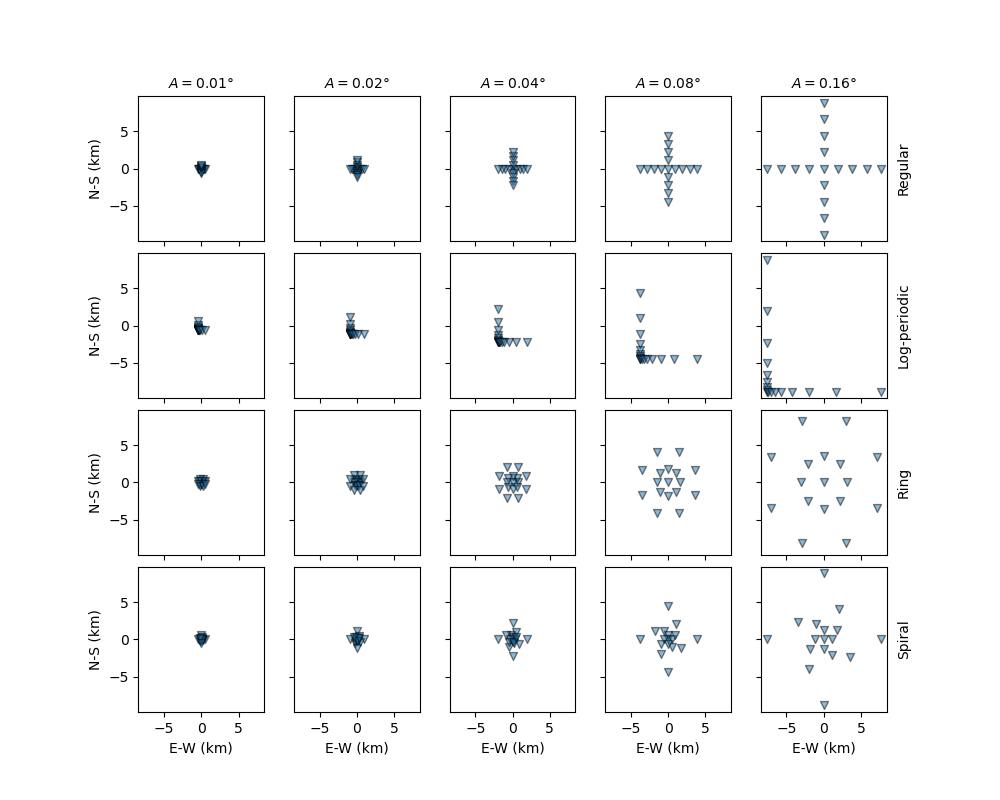

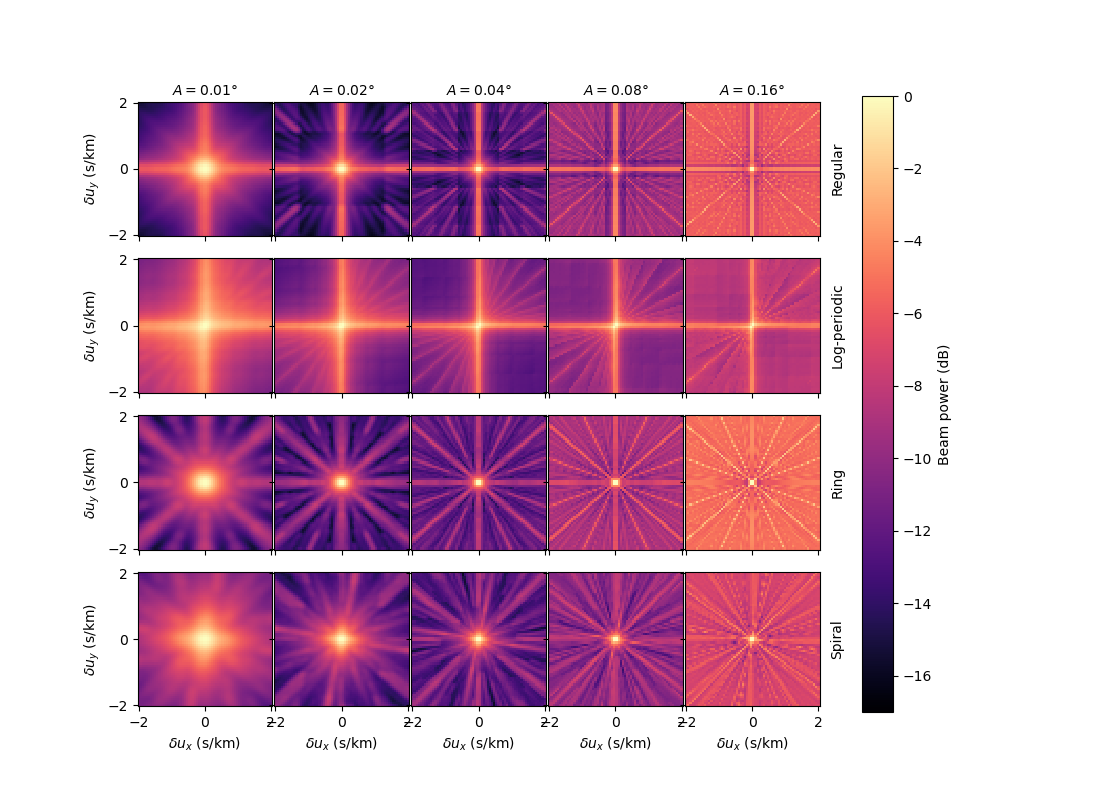

In [11]:
trace = impulse_trace.copy()

# Dimensions of analysis: aperture, n_rx, lo_freq, array_type
x_var = ('aperture', (0.01, 0.02, 0.04, 0.08, 0.16))
x_prefix, x_suffix = '$A = ', '\\degree$'

y_var = ('array_type', ('Regular', 'Log-periodic', 'Ring', 'Spiral'))
y_prefix, y_suffix = None, None

fixed_vars = dict(
    n_rx=16,
    lo_freq=1
)

label_kwargs = dict(
    x_prefix=x_prefix, 
    x_suffix=x_suffix, 
    y_prefix=y_prefix, 
    y_suffix=y_suffix
)
plt.close('all')
geoms = build_array_geometries(x_var, y_var, fixed_vars, constants)
plot_arrays(
    geoms, 
    x_var, 
    y_var, 
    fixed_vars, 
    **label_kwargs
)
plot_responses(
    geoms, 
    trace, 
    slo_grid, 
    x_var, 
    y_var, 
    fixed_vars,
    vmin=-17,
    **label_kwargs
)

## Number of receivers $N_{rx}$

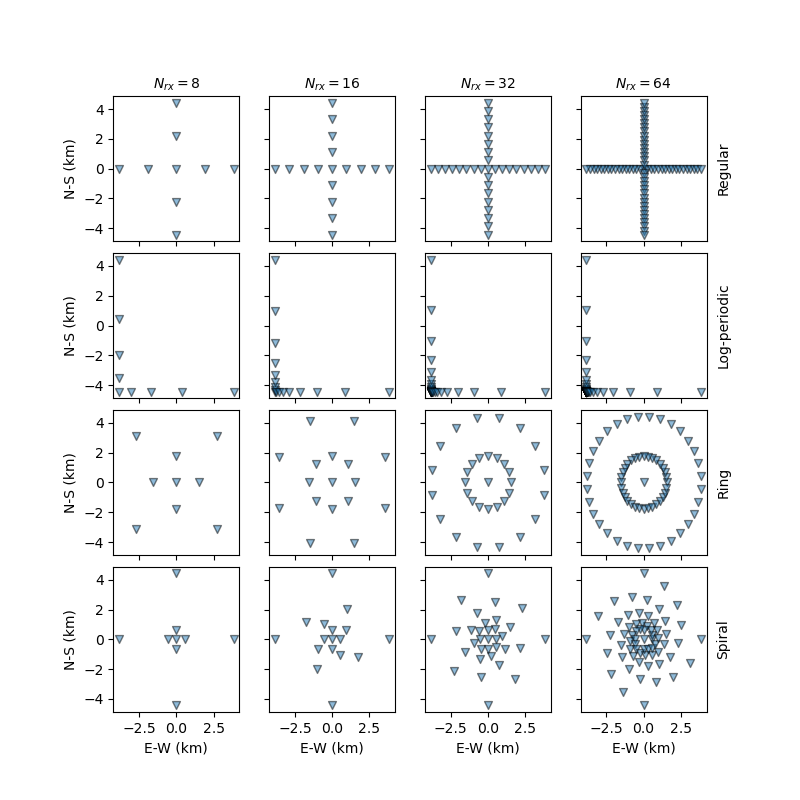

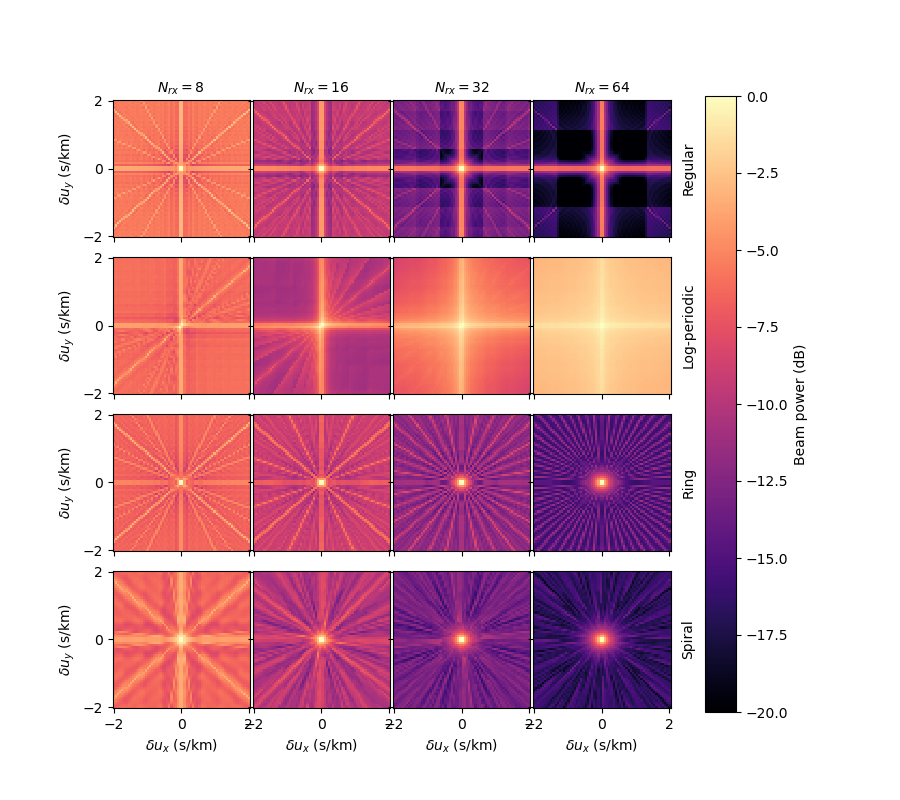

In [12]:
trace = impulse_trace

# Dimensions of analysis: aperture, n_rx, lo_freq, array_type
x_var = ('n_rx', (8, 16, 32, 64))
x_prefix, x_suffix = '$N_{rx} = ', '$'

y_var = ('array_type', ('Regular', 'Log-periodic', 'Ring', 'Spiral'))
y_prefix, y_suffix = None, None

fixed_vars = dict(
    aperture=0.08,
    lo_freq=1
)

label_kwargs = dict(
    x_prefix=x_prefix, 
    x_suffix=x_suffix, 
    y_prefix=y_prefix, 
    y_suffix=y_suffix
)
plt.close('all')
geoms = build_array_geometries(x_var, y_var, fixed_vars, constants)
plot_arrays(
    geoms, 
    x_var, 
    y_var, 
    fixed_vars, 
    **label_kwargs
)
plot_responses(
    geoms, 
    trace, 
    slo_grid, 
    x_var, 
    y_var, 
    fixed_vars,
    **label_kwargs
)

## Aperture $A$ versus number of receivers $N_{rx}$

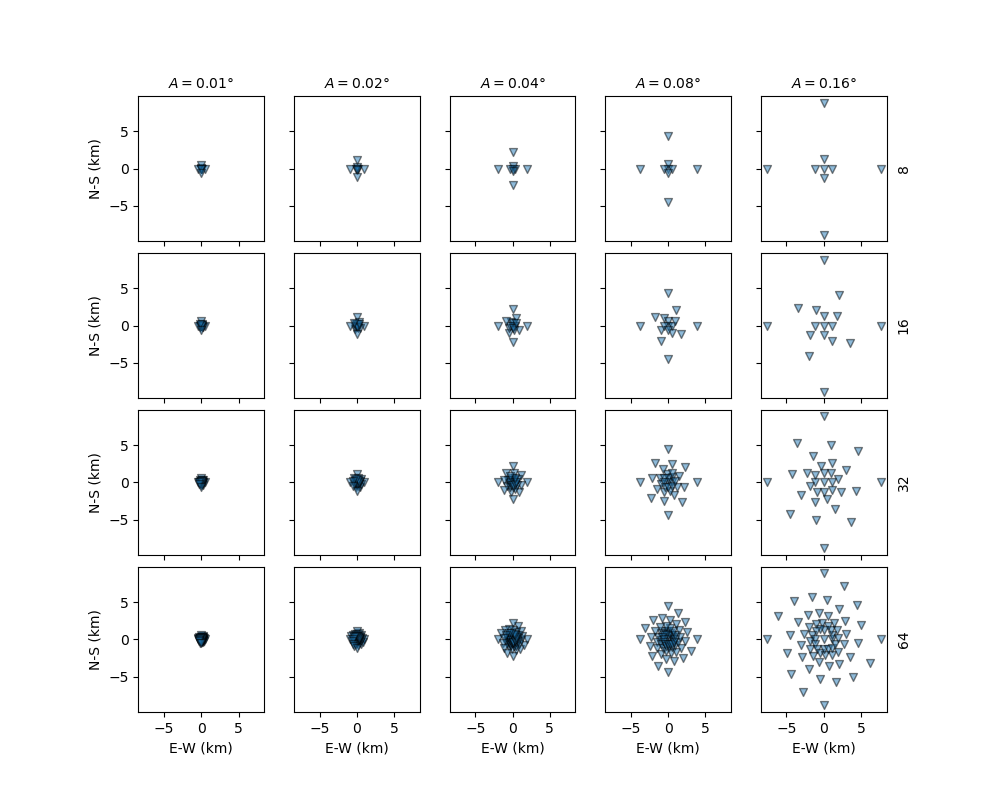

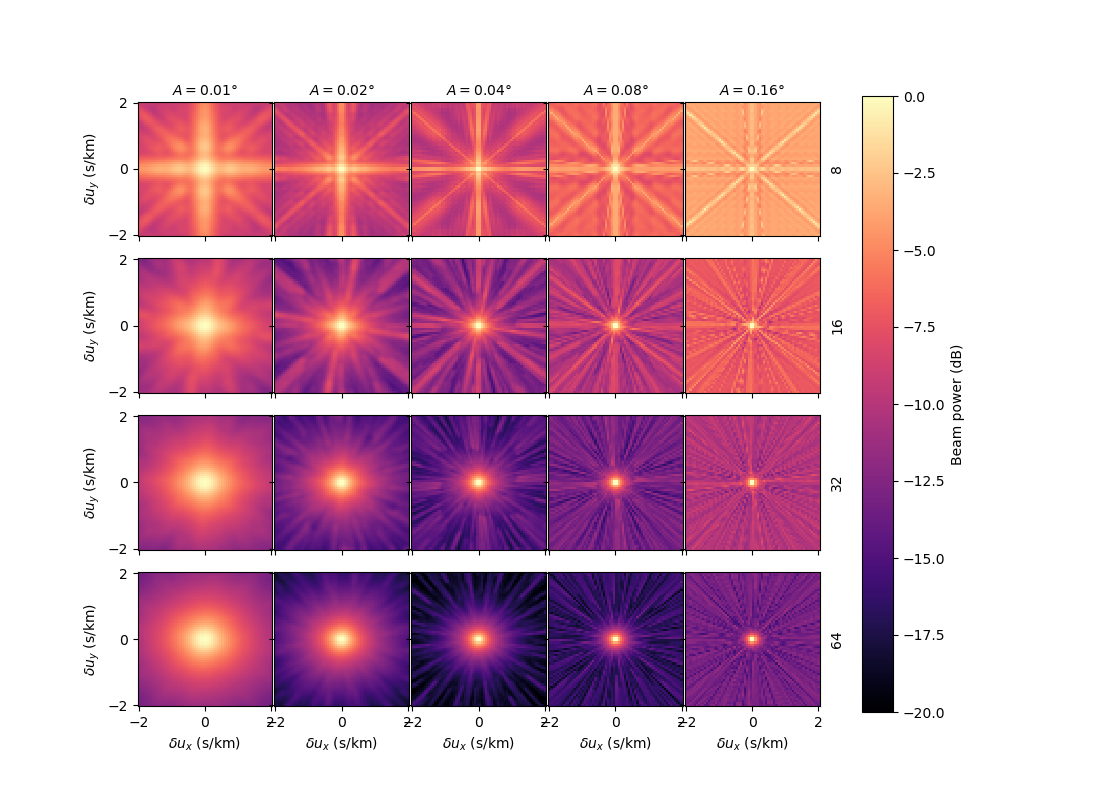

In [13]:
trace = impulse_trace

# Dimensions of analysis: aperture, n_rx, lo_freq, array_type
x_var = ('aperture', (0.01, 0.02, 0.04, 0.08, 0.16))
x_prefix, x_suffix = '$A = ', '\\degree$'

y_var = ('n_rx', (8, 16, 32, 64))
y_prefix, y_suffix = None, None

fixed_vars = dict(
    array_type='Spiral',
    lo_freq=1
)

label_kwargs = dict(
    x_prefix=x_prefix, 
    x_suffix=x_suffix, 
    y_prefix=y_prefix, 
    y_suffix=y_suffix
)
plt.close('all')
geoms = build_array_geometries(x_var, y_var, fixed_vars, constants)
plot_arrays(
    geoms, 
    x_var, 
    y_var, 
    fixed_vars, 
    **label_kwargs
)
plot_responses(
    geoms, 
    trace, 
    slo_grid, 
    x_var, 
    y_var, 
    fixed_vars,
    **label_kwargs
)

## Low corner frequency $\nu_{low}$

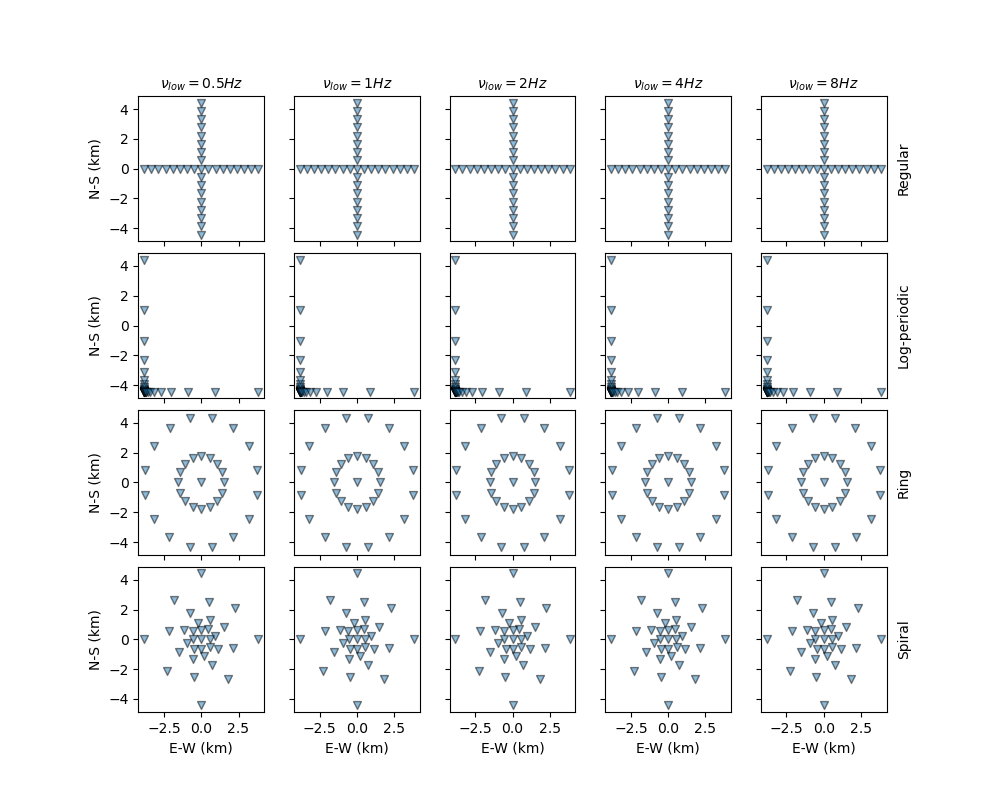

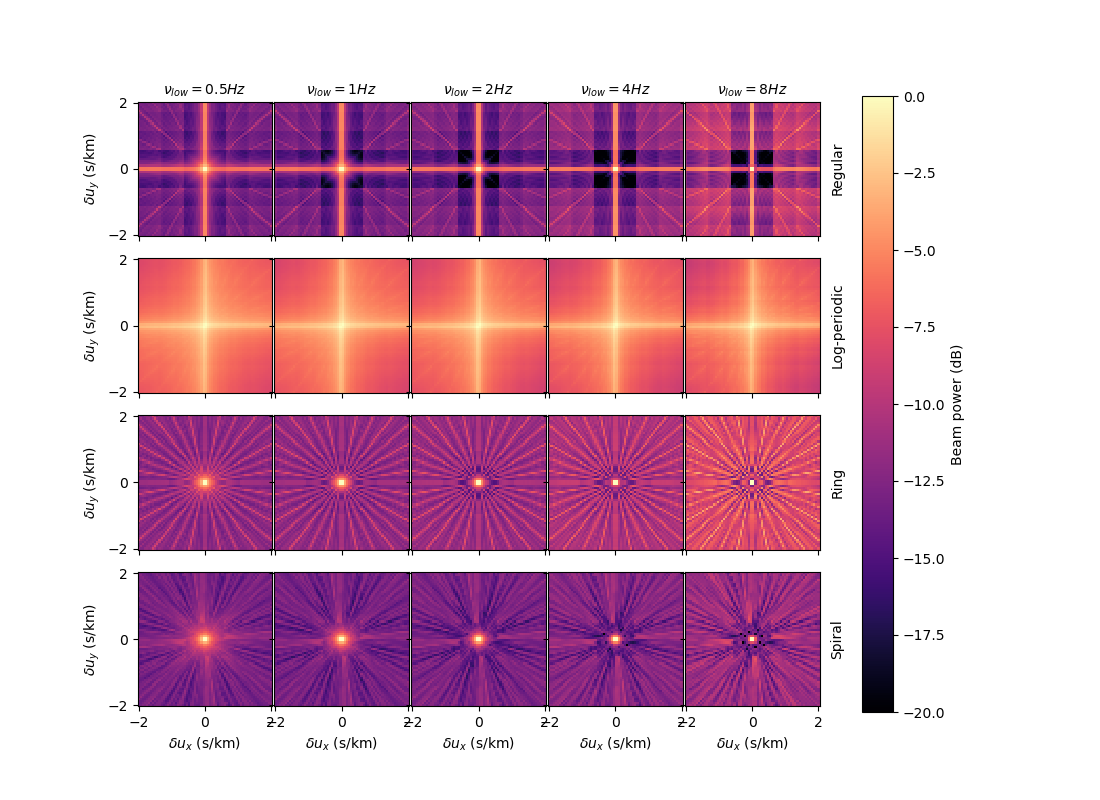

In [14]:
trace = impulse_trace

# Dimensions of analysis: aperture, n_rx, lo_freq, array_type
x_var = ('lo_freq', (1/2, 1, 2, 4, 8))
x_prefix, x_suffix = '$\\nu_{low} = ', 'Hz$'

y_var = ('array_type', ('Regular', 'Log-periodic', 'Ring', 'Spiral'))
y_prefix, y_suffix = None, None

fixed_vars = dict(
    aperture=0.08,
    n_rx=32
)

label_kwargs = dict(
    x_prefix=x_prefix, 
    x_suffix=x_suffix, 
    y_prefix=y_prefix, 
    y_suffix=y_suffix
)
plt.close('all')
geoms = build_array_geometries(x_var, y_var, fixed_vars, constants)
plot_arrays(
    geoms, 
    x_var, 
    y_var, 
    fixed_vars, 
    **label_kwargs
)
plot_responses(
    geoms, 
    trace, 
    slo_grid, 
    x_var, 
    y_var, 
    fixed_vars,
    **label_kwargs
)